
# Clasificación **resuelta**: Random Forest — Producción *Alta* vs *Baja*

Este cuaderno usa `1. datos_agricolas.xlsx` (hoja **Inicio**) para clasificar cada registro en **Producción Alta (1)** o **Baja (0)** según la mediana de `Producción_Ton`.  
Incluye carga de datos, EDA breve, creación del objetivo binario, *pipeline* de preprocesamiento + **RandomForestClassifier**, métricas, matriz de confusión, **ROC-AUC**, e **importancia de variables**. 


## 1) Importar librerías

In [3]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_auc_score, RocCurveDisplay
)

import matplotlib.pyplot as plt


## 2) Cargar datos

In [4]:

file_path = "ejercicio_1_datos_regresion_lineal_agricola.xlsx"  # Ajusta si ejecutas fuera de este entorno
df = pd.read_excel(file_path, sheet_name="Datos")
print(df.shape)
df.head()


(480, 10)


,Año,Mes,Región,Cultivo,Superficie_Ha,Producción_Ton,Precio_Ton,Costos_Insumos,Ingresos,Utilidad
0,2023,1,Norte,Maíz,122,749,316.95,12541,237319.70,224778.70
1,2023,1,Norte,Soja,141,422,273.40,2574,115405.98,112831.98
2,2023,1,Norte,Trigo,107,328,311.12,2543,101962.95,99419.95
3,2023,1,Norte,Manzana,363,2874,274.87,5428,789881.63,784453.63
4,2023,1,Norte,Tomate,211,1446,131.99,2363,190802.69,188439.69


## 3) EDA breve

In [5]:

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 480 entries, 0 to 479
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Año             480 non-null    int64  
 1   Mes             480 non-null    int64  
 2   Región          480 non-null    object 
 3   Cultivo         480 non-null    object 
 4   Superficie_Ha   480 non-null    int64  
 5   Producción_Ton  480 non-null    int64  
 6   Precio_Ton      480 non-null    float64
 7   Costos_Insumos  480 non-null    int64  
 8   Ingresos        480 non-null    float64
 9   Utilidad        480 non-null    float64
dtypes: float64(3), int64(5), object(2)
memory usage: 37.6+ KB


In [6]:

df.describe(include="all").T


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Año,480.0,NaN,NaN,NaN,2023.5,0.500522,2023.0,2023.0,2023.5,2024.0,2024.0
Mes,480.0,NaN,NaN,NaN,6.5,3.455654,1.0,3.75,6.5,9.25,12.0
Región,480,4,Norte,120,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Cultivo,480,5,Maíz,96,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Superficie_Ha,480.0,NaN,NaN,NaN,253.041667,141.376776,20.0,137.0,245.0,378.25,499.0
Producción_Ton,480.0,NaN,NaN,NaN,1613.71875,1157.53085,48.0,677.25,1314.5,2412.5,5403.0
Precio_Ton,480.0,NaN,NaN,NaN,254.586896,74.45154,100.09,193.8125,265.365,312.11,397.48
Costos_Insumos,480.0,NaN,NaN,NaN,10438.29375,5545.255615,1543.0,5399.5,10356.5,15137.25,19957.0
Ingresos,480.0,NaN,NaN,NaN,379991.904521,263489.847762,17546.34,179413.99,334503.955,515130.73,1451367.44
Utilidad,480.0,NaN,NaN,NaN,369553.610771,263795.833364,240.34,167052.425,322863.2,504072.8175,1442403.44


## 4) Crear variable objetivo binaria: Producción Alta vs Baja (umbral = mediana)

In [7]:

threshold = df["Producción_Ton"].median()
df["Produccion_Alta"] = (df["Producción_Ton"] > threshold).astype(int)

print("Umbral (mediana) de Producción_Ton:", threshold)
df["Produccion_Alta"].value_counts(dropna=False)


Umbral (mediana) de Producción_Ton: 1314.5


Produccion_Alta
0    240
1    240
Name: count, dtype: int64

## 5) Definir variables y Train/Test

In [8]:

target_col = "Produccion_Alta"
feature_cols = ["Año", "Mes", "Región", "Cultivo", "Superficie_Ha", "Precio_Ton", "Costos_Insumos"]

X = df[feature_cols].copy()
y = df[target_col].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

len(X_train), len(X_test), y_train.mean().round(3), y_test.mean().round(3)


(384, 96, 0.5, 0.5)

## 6) Preprocesamiento (numéricas y categóricas)

In [9]:

numeric_features = ["Año", "Mes", "Superficie_Ha", "Precio_Ton", "Costos_Insumos"]
categorical_features = ["Región", "Cultivo"]

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)


## 7) Entrenamiento del **RandomForestClassifier**

In [10]:

clf = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1))
])

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:, 1]
print("Modelo entrenado.")


Modelo entrenado.


## 8) Métricas de evaluación

In [11]:

acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.3f}\n")

print("Reporte de Clasificación:")
print(classification_report(y_test, y_pred, digits=3))


Accuracy: 0.938

Reporte de Clasificación:
              precision    recall  f1-score   support

           0      0.938     0.938     0.938        48
           1      0.938     0.938     0.938        48

    accuracy                          0.938        96
   macro avg      0.938     0.938     0.938        96
weighted avg      0.938     0.938     0.938        96



## 9) Matriz de confusión

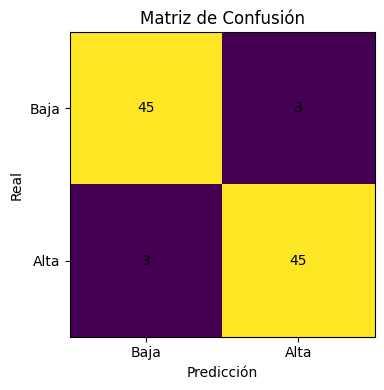

In [12]:

cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(4,4))
im = ax.imshow(cm, interpolation='nearest')
ax.set_title("Matriz de Confusión")
ax.set_xlabel("Predicción")
ax.set_ylabel("Real")
ax.set_xticks([0,1])
ax.set_yticks([0,1])
ax.set_xticklabels(["Baja","Alta"])
ax.set_yticklabels(["Baja","Alta"])

# Anotar valores
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j], ha="center", va="center")

plt.tight_layout()
plt.show()


## 10) ROC-AUC y curva ROC

ROC-AUC: 0.984


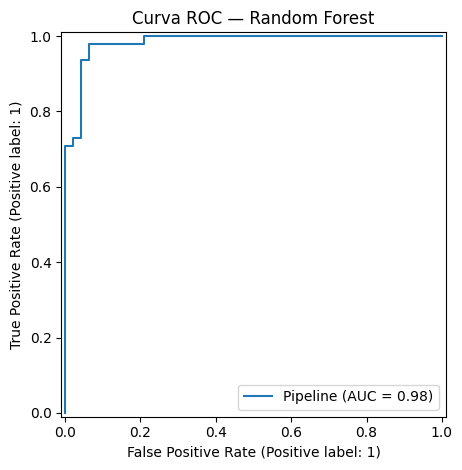

In [13]:

roc_auc = roc_auc_score(y_test, y_proba)
print(f"ROC-AUC: {roc_auc:.3f}")

RocCurveDisplay.from_estimator(clf, X_test, y_test)
plt.title("Curva ROC — Random Forest")
plt.tight_layout()
plt.show()


## 11) Importancia de variables (Top 15)

In [14]:

# Recuperar nombres tras One-Hot
ohe = clf.named_steps["preprocessor"].named_transformers_["cat"].named_steps["onehot"]
cat_feature_names = list(ohe.get_feature_names_out(categorical_features))
all_features = numeric_features + cat_feature_names

rf = clf.named_steps["model"]
importances = rf.feature_importances_

imp_df = pd.DataFrame({"feature": all_features, "importance": importances})\
          .sort_values("importance", ascending=False)

imp_df.head(15)


,feature,importance
2,Superficie_Ha,0.513235
3,Precio_Ton,0.127057
4,Costos_Insumos,0.077439
1,Mes,0.060153
11,Cultivo_Soja,0.059565
13,Cultivo_Trigo,0.033442
9,Cultivo_Manzana,0.031141
12,Cultivo_Tomate,0.017775
10,Cultivo_Maíz,0.016864
0,Año,0.015403


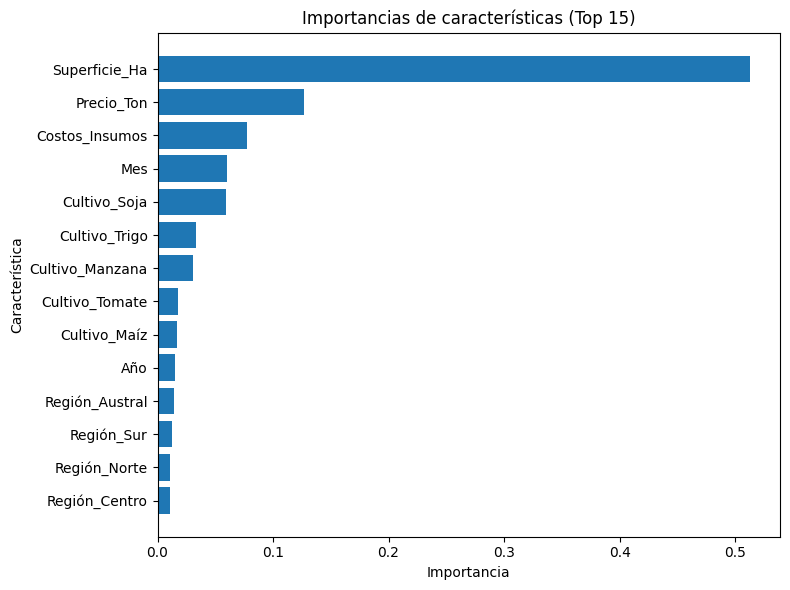

In [15]:

top = imp_df.head(15)
plt.figure(figsize=(8,6))
plt.barh(top["feature"][::-1], top["importance"][::-1])
plt.xlabel("Importancia")
plt.ylabel("Característica")
plt.title("Importancias de características (Top 15)")
plt.tight_layout()
plt.show()


## 12) (Opcional) Validación cruzada (accuracy y ROC-AUC)

In [16]:

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_acc = cross_val_score(clf, X, y, cv=skf, scoring="accuracy")
cv_roc = cross_val_score(clf, X, y, cv=skf, scoring="roc_auc")

print("=== Validación Cruzada (5-fold) ===")
print(f"Accuracy folds : {np.round(cv_acc, 3)}  ->  media±std: {cv_acc.mean():.3f} ± {cv_acc.std():.3f}")
print(f"ROC-AUC  folds : {np.round(cv_roc, 3)}  ->  media±std: {cv_roc.mean():.3f} ± {cv_roc.std():.3f}")


=== Validación Cruzada (5-fold) ===
Accuracy folds : [0.906 0.927 0.917 0.927 0.958]  ->  media±std: 0.927 ± 0.017
ROC-AUC  folds : [0.969 0.992 0.972 0.974 0.976]  ->  media±std: 0.977 ± 0.008
